In [1]:
import warnings
warnings.simplefilter('ignore')
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from IPython.display import display, HTML
import sklearn
from sklearn import tree
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline


#import os
#from numpy.random import randn
#from copy import copy
#from update import update

In [2]:
dataset_filename ='/home/ck4vadla/Prescription_Based_PredictionXgboost/roam_predcription_based_predicition_c.jsonl'
dataframe_main = pd.DataFrame()
data = ''
with open(dataset_filename) as json_data:
        data = json.load(json_data)
        dataframe_main= json_normalize(data)
json_data.close()


In [3]:
dataframe_main.shape

(239930, 2405)

dataframe_main.describe()

**simplifie the column name
<br/>check fro repeating column names
<br/> Check for invalide column name like white spaces etc**

In [4]:
#parts = (label.strip().split('.') for label in dataframe_main.columns.values)
column_names_list = dataframe_main.columns.values.tolist()
index_npi = column_names_list.index('npi')
column_names_list.remove('npi')

parts = [lable.strip(' \t\n\r').split('.',1) for lable in column_names_list] 
parts1 =  [parts_iter[0] for parts_iter in parts]
#len(parts)
column_name_new =  [parts_iter[1] for parts_iter in parts]
column_name_new.insert(index_npi,'npi')
#print index_npi
print len(column_name_new)
column_name_new

2405


[u'1ST TIER UNIFINE PENTIPS',
 u'ABACAVIR',
 u'ABELCET',
 u'ABILIFY',
 u'ABILIFY DISCMELT',
 u'ABILIFY MAINTENA',
 u'ABRAXANE',
 u'ABSTRAL',
 u'ACAMPROSATE CALCIUM',
 u'ACANYA',
 u'ACARBOSE',
 u'ACCOLATE',
 u'ACCUNEB',
 u'ACCUPRIL',
 u'ACEBUTOLOL HCL',
 u'ACETAMINOPH-CAFF-DIHYDROCODEIN',
 u'ACETAMINOPHEN-BUTALBITAL',
 u'ACETAMINOPHEN-CODEINE',
 u'ACETAZOLAMIDE',
 u'ACETIC ACID',
 u'ACETIC ACID-ALUMINUM',
 u'ACETYLCYSTEINE',
 u'ACIPHEX',
 u'ACITRETIN',
 u'ACTEMRA',
 u'ACTIGALL',
 u'ACTIMMUNE',
 u'ACTIQ',
 u'ACTIVELLA',
 u'ACTONEL',
 u'ACTOPLUS MET',
 u'ACTOPLUS MET XR',
 u'ACTOS',
 u'ACYCLOVIR',
 u'ACZONE',
 u'ADACEL TDAP',
 u'ADALAT CC',
 u'ADAPALENE',
 u'ADCIRCA',
 u'ADDERALL',
 u'ADDERALL XR',
 u'ADRUCIL',
 u'ADVAIR DISKUS',
 u'ADVAIR HFA',
 u'ADVICOR',
 u'ADVOCATE PEN NEEDLES',
 u'AFEDITAB CR',
 u'AFINITOR',
 u'AGGRENOX',
 u'AGRYLIN',
 u'AIMSCO ULTRA THIN II',
 u'AK-POLY-BAC',
 u'ALBENZA',
 u'ALBUTEIN',
 u'ALBUTEROL SULFATE',
 u'ALCLOMETASONE DIPROPIONATE',
 u'ALCOHOL PADS',
 u'ALCO

create a dataframe out of parts and use shape to check if there are any rows with more than two values

In [5]:
df_check = pd.DataFrame(parts)
df_check.shape

(2404, 2)

There are only 2 columns

create a dataframe out of parts1 and see if all the name are either  'cms_prescription_counts' or 
'provider_variables'. use groupby() to do this


In [6]:
#parts1.append(' ')
df_names_check = pd.DataFrame(parts1, columns=['titles'])
counts = df_names_check.groupby(["titles"]).size()
display (counts)
print "total number of rows is:", len(df_names_check['titles'])
print "cms_prescription_counts + provider_variables", counts['cms_prescription_counts']+counts['provider_variables']

titles
cms_prescription_counts    2397
provider_variables            7
dtype: int64

total number of rows is: 2404
cms_prescription_counts + provider_variables 2404


The sum of number of cms_prescription_counts's and provider_variables's is correct(1 less because we removed 'npi') and we cannot see and invalid entries 
there

In [7]:
print len(column_names_list)

2404


now check column_name_new for duplicates and invalid names like ''

In [8]:
column_name_new_striped = [x.strip(' \t\n\r') for x in column_name_new]
print len(column_name_new_striped)
#print column_name_new_striped

df_new_names_check = pd.DataFrame(column_name_new_striped, columns=['label']).groupby(['label']).size().reset_index()
df_new_names_check.columns = ['label', 'counts']

display (df_new_names_check.query("counts != 1" ))
display (df_new_names_check.query(("label == ''")))
display (df_new_names_check.query("label == ' '"))


df_new_names_check.mean()

2405


,label,counts


,label,counts


,label,counts


counts    1.0
dtype: float64

The mean is 1.0 which mean all the labels appear only once and there are no duplicates also there are no empty string for column names 

**Now remove the cms_prescription_counts and provider_variables from the titles and have a cleaner names

replace the column name inplace uisng the lists column_names_list and column_name_new_striped

In [9]:
column_names_list.insert(index_npi,'npi')


In [10]:
#dataframe_main.columns = column_name_new_striped
new_names_dict = {}
for i in range(0,len(column_names_list)):
    new_names_dict[column_names_list[i]] =  column_name_new_striped[i]
print len(new_names_dict)

2405


In [11]:
new_names_dict

{u'cms_prescription_counts.VELIVET': u'VELIVET',
 u'cms_prescription_counts.UNIVASC': u'UNIVASC',
 u'cms_prescription_counts.SORIATANE': u'SORIATANE',
 u'cms_prescription_counts.GENERLAC': u'GENERLAC',
 u'cms_prescription_counts.LEVITRA': u'LEVITRA',
 u'cms_prescription_counts.PROPRANOLOL-HYDROCHLOROTHIAZID': u'PROPRANOLOL-HYDROCHLOROTHIAZID',
 u'cms_prescription_counts.XERESE': u'XERESE',
 u'cms_prescription_counts.NOR-Q-D': u'NOR-Q-D',
 u'cms_prescription_counts.ADVICOR': u'ADVICOR',
 u'cms_prescription_counts.ANAGRELIDE HCL': u'ANAGRELIDE HCL',
 u'cms_prescription_counts.BROMDAY': u'BROMDAY',
 u'cms_prescription_counts.HECTOROL': u'HECTOROL',
 u'cms_prescription_counts.DILANTIN': u'DILANTIN',
 u'cms_prescription_counts.VERAPAMIL ER PM': u'VERAPAMIL ER PM',
 u'cms_prescription_counts.STARLIX': u'STARLIX',
 u'cms_prescription_counts.AZOPT': u'AZOPT',
 u'cms_prescription_counts.EQUETRO': u'EQUETRO',
 u'cms_prescription_counts.NARDIL': u'NARDIL',
 u'cms_prescription_counts.LO LOESTRIN F

In [12]:
dataframe_main.rename(columns=new_names_dict, inplace=True)

In [13]:
#dataframe_main.head()

**Uniqueness of npi**

</br>Check for dupliate values of "npi".

In [14]:
df_npi_dulicates= pd.DataFrame(dataframe_main["npi"],columns=['npi']).duplicated("npi",keep=False).to_frame(name="res")

In [15]:
df_npi_dulicates.groupby('res').size()

res
False    239930
dtype: int64

There are no duplicates in the npi

In [16]:
df_specialty_count = pd.DataFrame({'counts' : dataframe_main.groupby( [ "specialty"] , sort=False).size()}).reset_index()
df_specialty_count.sort_values(['counts'], ascending=True, inplace=True)
df_specialty_count#.head(20)

,specialty,counts
281,Continuing Education/Staff Development,1
250,"Nursing Care, Pediatric",1
249,Pulmonary Diagnostics,1
247,Chronic Care,1
245,"Family Planning, Non-Surgical",1
242,Neuropathology,1
238,In Vivo & In Vitro Nuclear Medicine,1
235,Forensic Pathology,1
234,Long-Term Care,1
231,Pastoral,1


In [17]:
def validRowsForSpecialty(specialty,how):
    temp = dataframe_main.ix[dataframe_main.specialty == specialty]
    temp.dropna(axis=1,how='all', inplace=True) #delete columns that are all NaN
    temp1 = temp.columns.values   #these are the columns corresponding to the given specialty 
    temp1 = temp1[:-8]        # deleting unnecessary column names npi ,brand_name_rx_count ,gender ,generic_rx_count ,region ,settlement_type ,specialty and years_practicing
    temp2 = np.append(temp1, 'specialty') 

    dataframe_MaternalNewborn_columns = dataframe_main[temp2]
    dataframe_MaternalNewborn_columns.dropna(axis=0, how=how, subset=temp1, inplace=True) # delete row that have any/all NaN values
    display(dataframe_MaternalNewborn_columns)
    

    


In [18]:
validRowsForSpecialty('Behavioral Neurology & Neuropsychiatry', 'all')

,ABILIFY,ALLOPURINOL,ALPRAZOLAM,AMANTADINE,AMBIEN,AMBIEN CR,AMITRIPTYLINE HCL,AMLODIPINE BESYLATE,AMPHETAMINE SALT COMBO,BACLOFEN,...,TRIFLUOPERAZINE HCL,TRIHEXYPHENIDYL HCL,VENLAFAXINE HCL,VENLAFAXINE HCL ER,VYVANSE,WELLBUTRIN XL,ZIPRASIDONE HCL,ZOLPIDEM TARTRATE,ZYPREXA,specialty
0,11.0,86.0,45.0,NaN,NaN,NaN,NaN,175.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,NaN,Nephrology
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
4,NaN,19.0,NaN,NaN,NaN,NaN,NaN,79.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,Nephrology
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gastroenterology
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,Psychiatry
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
12,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rheumatology
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gastroenterology
15,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN,Plastic and Reconstructive Surgery


In [19]:
validRowsForSpecialty('Behavioral Neurology & Neuropsychiatry', 'any')

,ABILIFY,ALLOPURINOL,ALPRAZOLAM,AMANTADINE,AMBIEN,AMBIEN CR,AMITRIPTYLINE HCL,AMLODIPINE BESYLATE,AMPHETAMINE SALT COMBO,BACLOFEN,...,TRIFLUOPERAZINE HCL,TRIHEXYPHENIDYL HCL,VENLAFAXINE HCL,VENLAFAXINE HCL ER,VYVANSE,WELLBUTRIN XL,ZIPRASIDONE HCL,ZOLPIDEM TARTRATE,ZYPREXA,specialty


In [20]:
validRowsForSpecialty('Psychiatry', 'any')

,ABILIFY,ABILIFY DISCMELT,ABILIFY MAINTENA,ACAMPROSATE CALCIUM,ACARBOSE,ACCUPRIL,ACEBUTOLOL HCL,ACETAMINOPHEN-BUTALBITAL,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,...,ZOMIG ZMT,ZONEGRAN,ZONISAMIDE,ZOSTAVAX,ZOVIA 1-35E,ZYMAXID,ZYPREXA,ZYPREXA RELPREVV,ZYPREXA ZYDIS,specialty


In [21]:
temp4 = dataframe_main.ix[dataframe_main.specialty == 'Psychiatry']
temp4.dropna(axis=1, how='all', inplace=True)
temp4.shape

(22530, 1036)

In [22]:
validRowsForSpecialty('Maternal Newborn', 'any')

,AZURETTE,ESTRACE,JUNEL FE,MEDROXYPROGESTERONE ACETATE,PREMARIN,specialty
17686,15.0,11.0,32.0,16.0,31.0,Maternal Newborn


In [23]:
validRowsForSpecialty('Maternal Newborn', 'all')

,AZURETTE,ESTRACE,JUNEL FE,MEDROXYPROGESTERONE ACETATE,PREMARIN,specialty
62,NaN,NaN,NaN,21.0,NaN,Medical
92,NaN,NaN,NaN,NaN,22.0,Gynecology
109,NaN,NaN,NaN,NaN,22.0,Pulmonary Disease
131,NaN,NaN,NaN,NaN,17.0,Women's Health
322,NaN,NaN,NaN,NaN,12.0,Family
348,NaN,17.0,NaN,43.0,107.0,Gynecology
356,NaN,18.0,NaN,NaN,32.0,Family
400,NaN,48.0,NaN,NaN,NaN,Gynecologic Oncology
406,NaN,NaN,NaN,NaN,50.0,Family
411,NaN,NaN,NaN,NaN,14.0,Family


In [24]:
validRowsForSpecialty('Dental Public Health', 'all')

,ACETAMINOPHEN-CODEINE,ALPRAZOLAM,AMOX TR-POTASSIUM CLAVULANATE,AMOXICILLIN,AMPICILLIN TRIHYDRATE,AZITHROMYCIN,CEFADROXIL,CEPHALEXIN,CHLORHEXIDINE GLUCONATE,CIPROFLOXACIN HCL,...,POTASSIUM CHLORIDE,PREVIDENT 5000,PREVIDENT 5000 PLUS,PREVIDENT 5000 SENSITIVE,SF,SF 5000 PLUS,TRAMADOL HCL,TRAZODONE HCL,ZOLPIDEM TARTRATE,specialty
0,NaN,45.0,NaN,NaN,NaN,18.0,NaN,NaN,NaN,19.0,...,30.0,NaN,NaN,NaN,NaN,NaN,11.0,NaN,41.0,Nephrology
1,NaN,NaN,NaN,52.0,NaN,NaN,NaN,23.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,28.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
3,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
4,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,Nephrology
5,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
6,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Endodontics
8,NaN,NaN,15.0,NaN,NaN,31.0,NaN,17.0,NaN,14.0,...,33.0,NaN,NaN,NaN,NaN,NaN,NaN,65.0,NaN,Gastroenterology
9,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice


In [25]:
validRowsForSpecialty('Dental Public Health', 'any')

,ACETAMINOPHEN-CODEINE,ALPRAZOLAM,AMOX TR-POTASSIUM CLAVULANATE,AMOXICILLIN,AMPICILLIN TRIHYDRATE,AZITHROMYCIN,CEFADROXIL,CEPHALEXIN,CHLORHEXIDINE GLUCONATE,CIPROFLOXACIN HCL,...,POTASSIUM CHLORIDE,PREVIDENT 5000,PREVIDENT 5000 PLUS,PREVIDENT 5000 SENSITIVE,SF,SF 5000 PLUS,TRAMADOL HCL,TRAZODONE HCL,ZOLPIDEM TARTRATE,specialty


In [26]:
validRowsForSpecialty('Surgery of the Hand', 'all')
validRowsForSpecialty('Surgery of the Hand', 'any')

,ACETAMINOPHEN-CODEINE,ACYCLOVIR,ALLOPURINOL,ALPRAZOLAM,AMITRIPTYLINE HCL,AMLODIPINE BESYLATE,AMOX TR-POTASSIUM CLAVULANATE,AMOXICILLIN,ATENOLOL,ATORVASTATIN CALCIUM,...,TRAMADOL HCL,TRAMADOL HCL-ACETAMINOPHEN,TRETINOIN,TRIAMCINOLONE ACETONIDE,VALACYCLOVIR,VESICARE,VOLTAREN,ZOLPIDEM TARTRATE,ZOSTAVAX,specialty
0,NaN,NaN,86.0,45.0,NaN,175.0,NaN,NaN,62.0,19.0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,41.0,NaN,Nephrology
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
4,NaN,NaN,19.0,NaN,NaN,79.0,NaN,12.0,48.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,Nephrology
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Endodontics
8,NaN,NaN,NaN,NaN,NaN,69.0,15.0,NaN,NaN,68.0,...,NaN,NaN,NaN,15.0,NaN,NaN,17.0,NaN,NaN,Gastroenterology
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice


,ACETAMINOPHEN-CODEINE,ACYCLOVIR,ALLOPURINOL,ALPRAZOLAM,AMITRIPTYLINE HCL,AMLODIPINE BESYLATE,AMOX TR-POTASSIUM CLAVULANATE,AMOXICILLIN,ATENOLOL,ATORVASTATIN CALCIUM,...,TRAMADOL HCL,TRAMADOL HCL-ACETAMINOPHEN,TRETINOIN,TRIAMCINOLONE ACETONIDE,VALACYCLOVIR,VESICARE,VOLTAREN,ZOLPIDEM TARTRATE,ZOSTAVAX,specialty


In [27]:
validRowsForSpecialty('Sleep Medicine', 'all')
validRowsForSpecialty('Sleep Medicine', 'any')

,ABILIFY,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,ACTONEL,ACYCLOVIR,ADDERALL,ADDERALL XR,ADVAIR DISKUS,ADVICOR,AGGRENOX,...,ZETIA,ZIPRASIDONE HCL,ZOLMITRIPTAN,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZOLPIMIST,ZONEGRAN,ZONISAMIDE,ZOSTAVAX,specialty
0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,41.0,NaN,NaN,NaN,NaN,NaN,Nephrology
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
4,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,Nephrology
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Endodontics
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gastroenterology
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,General Practice


,ABILIFY,ACETAMINOPHEN-CODEINE,ACETAZOLAMIDE,ACTONEL,ACYCLOVIR,ADDERALL,ADDERALL XR,ADVAIR DISKUS,ADVICOR,AGGRENOX,...,ZETIA,ZIPRASIDONE HCL,ZOLMITRIPTAN,ZOLPIDEM TARTRATE,ZOLPIDEM TARTRATE ER,ZOLPIMIST,ZONEGRAN,ZONISAMIDE,ZOSTAVAX,specialty


This show that the drugs prescribed for Debtal Public Health are not completely specific to this specialty but are also prescribed by other specialties
there fore these  drugs cannot give us any clear indicators for prediction

this shows that the columns Azurette, Estrac, Junel FE, MEDROXYPROGESTERONE ACETATE and premarin are filled only for the specilization Maternal Newborn

In [28]:
#df["gender"].describe()
df_gender = dataframe_main.groupby(['gender']).size().reset_index()
#print "number of :", df_gender.count()
display (df_gender)
df_gender.describe()

,gender,0
0,F,90273
1,M,149657


,0
count,2.000000
mean,119965.000000
std,41990.829094
min,90273.000000
25%,105119.000000
50%,119965.000000
75%,134811.000000
max,149657.000000


In [29]:
#df["years_practicing"].describe()
df_years_practicing = dataframe_main.groupby(['years_practicing']).size().reset_index()
display (df_years_practicing)
df_years_practicing.describe()

,years_practicing,0
0,1,7458
1,2,7735
2,3,7737
3,4,8187
4,5,13306
5,6,47160
6,7,117540
7,8,30807


,years_practicing,0
count,8.00000,8.000000
mean,4.50000,29991.250000
std,2.44949,38195.694596
min,1.00000,7458.000000
25%,2.75000,7736.500000
50%,4.50000,10746.500000
75%,6.25000,34895.250000
max,8.00000,117540.000000


In [30]:
dataframe_main["region"].describe()
df_region = dataframe_main.groupby(['region']).size().reset_index()
display (df_region)
df_region.describe()

,region,0
0,Midwest,50077
1,Northeast,59012
2,South,80562
3,West,50279


,0
count,4.000000
mean,59982.500000
std,14337.997687
min,50077.000000
25%,50228.500000
50%,54645.500000
75%,64399.500000
max,80562.000000


In [31]:
dataframe_main["settlement_type"].describe()
df_settlement_type = dataframe_main.groupby(['settlement_type']).size().reset_index()
display (df_settlement_type)
df_settlement_type.describe()

,settlement_type,0
0,non-urban,152270
1,urban,87660


,0
count,2.000000
mean,119965.000000
std,45686.169132
min,87660.000000
25%,103812.500000
50%,119965.000000
75%,136117.500000
max,152270.000000


In [32]:
dataframe_main["generic_rx_count"].describe()


count    239930.000000
mean        795.547047
std        1809.618284
min           0.000000
25%          36.000000
50%         145.000000
75%         750.000000
max      101079.000000
Name: generic_rx_count, dtype: float64

In [33]:
dataframe_main["brand_name_rx_count"].describe()

count    239930.000000
mean        176.264144
std         475.159281
min           0.000000
25%           0.000000
50%          15.000000
75%         154.000000
max       30547.000000
Name: brand_name_rx_count, dtype: float64

within the specialty General Practice is there any trend to suggest 
    1) different doctors from different regions tend to prescribe differently
    2) different doctors from different settlement's tend to prescribe differently
    3) doctors of different years of practice tend to prescribe differently

In [35]:
#
df_specialty_count.sort_values(['counts'], ascending=False, inplace=True)
type (df_specialty_count)
display (df_specialty_count.head(5))
#for i in df_specialty_count.head(5)['specialty']:
#    print i

,specialty,counts
1,General Practice,47836
10,Family,24230
4,Psychiatry,22530
9,Cardiovascular Disease,13091
18,Medical,12445


FEATURE SELECTION
<br/>toss out irrelevent features

In [36]:
#This function shall be used to identify the columns that have very few entries 
# these columns will not be of much use to analyse any pattern 

def columnsWithVeryFewValues(df_specialty_GP, percent):
    fewENtriesCount = 0
    validRowValues = int(df_specialty_GP.shape[0]*percent/100) #atleast 0.5% of rows have valid entries
    fewENtriesColumns = []

    for feature in df_specialty_GP.columns.values:
        a = df_specialty_GP[feature].count()
        if validRowValues > a:
            fewENtriesColumns.append(feature)
            fewENtriesCount = fewENtriesCount+1
    print "There are ", fewENtriesCount, "columns out of ",len(df_specialty_GP.keys()), "with less than " , validRowValues, " entries" 
    return fewENtriesColumns


In [37]:

def plotSettlementBasedDistribution(df_specialty_SType):
    
    #df_specialty_GP.groupby(["settlement_type"]).size()

    df_specialty_count = df_specialty_SType.groupby(["settlement_type"]).count()
    df_specialty_sum = df_specialty_SType.groupby(["settlement_type"], as_index=True).sum()
    
    df_specialty_count_T = df_specialty_count.transpose()
    df_specialty_sum_T = df_specialty_sum.transpose()

    #df_specialty_count_sum_T = pd.DataFrame(df_specialty_GP_count_T.values.sum(axis=1))

    df_specialty_normalized = pd.DataFrame((df_specialty_sum_T.values / df_specialty_count_T.values)                                 
                                     , columns=[elt for elt in df_specialty_sum_T.columns + "_normalized"]
                                     , index=df_specialty_count_T.index)

    my_plot = df_specialty_normalized.plot(kind='bar',stacked=False,title="Average drugs prescribed based on settlement type", figsize=(20,10) )
    my_plot.set_xlabel("Drugs")
    my_plot.set_ylabel("Average")
    

    #find the lesser of the two settlements
    array_lesser = np.where((df_specialty_normalized['non-urban_normalized']<df_specialty_normalized['urban_normalized']),
                                df_specialty_normalized['non-urban_normalized'], df_specialty_normalized['urban_normalized'])

    df_specialty_percent_diff = pd.DataFrame((abs(df_specialty_normalized['non-urban_normalized']-df_specialty_normalized['urban_normalized'])), columns=['difference'])

    df_specialty_percent_diff['Lesser'] = array_lesser

    df_specialty_percent_diff['percentage'] = pd.DataFrame(df_specialty_percent_diff.difference / df_specialty_percent_diff.Lesser * 100)

    if 'difference' in df_specialty_percent_diff.columns:
        df_specialty_percent_diff = df_specialty_percent_diff.drop(['difference' ], axis=1, inplace=False)

    if 'Lesser' in df_specialty_percent_diff.columns:
        df_specialty_percent_diff = df_specialty_percent_diff.drop( ['Lesser' ], axis=1, inplace=False)


    my_plot = df_specialty_percent_diff.plot(kind='bar',stacked=False,title="Percentage difference for drugs prescribed between the two settlement types", figsize=(15,5))
    my_plot.set_xlabel("Drugs")
    my_plot.set_ylabel("Percentage difference")

In [38]:
def plotRegionBasedDistribution(df_specialty_Region):
    df_specialty_Region_count = df_specialty_Region.groupby(["region"]).count()
    df_specialty_Region_sum = df_specialty_Region.groupby(["region"]).sum()

    df_specialty_Region_count_T = df_specialty_Region_count.transpose()
    df_specialty_Region_sum_T = df_specialty_Region_sum.transpose()
    
    df_specialty_Region_grouped_normalized = pd.DataFrame((df_specialty_Region_sum_T.values / df_specialty_Region_count_T.values)                                 
                                     , columns=[elt for elt in df_specialty_Region_sum_T.columns + "_normalized"]
                                     , index=df_specialty_Region_count_T.index)

    my_plot = df_specialty_Region_grouped_normalized.plot(kind='bar',stacked=False,title="Region Based plotiong of normalized drug prescription", figsize=(20,10))
    my_plot.set_xlabel("Drugs")
    my_plot.set_ylabel("Average")

In [39]:
def plotSTandRegionBasedDistribution(df_specialty_Re_ST):
    df_specialty_Region_ST_count = df_specialty_Re_ST.groupby(["region", "settlement_type"], as_index=False).count()
    df_specialty_Region_ST_sum = df_specialty_Re_ST.groupby(["region", "settlement_type"], as_index=False).sum()

    df_specialty_Region_ST_count['region-st'] = df_specialty_Region_ST_count[['region', 'settlement_type']].apply(lambda x: '_'.join(x), axis=1)
    df_specialty_Region_ST_sum['region-st'] = df_specialty_Region_ST_sum[['region', 'settlement_type']].apply(lambda x: '_'.join(x), axis=1)

    df_specialty_Region_ST_count = df_specialty_Region_ST_count.drop(['region', 'settlement_type'], axis=1, inplace=False)
    df_specialty_Region_ST_sum = df_specialty_Region_ST_sum.drop(['region', 'settlement_type'], axis=1, inplace=False)


    df_specialty_Region_ST_count = df_specialty_Region_ST_count.set_index("region-st")
    df_specialty_Region_ST_sum = df_specialty_Region_ST_sum.set_index("region-st")

    df_specialty_Region_ST_count_T = df_specialty_Region_ST_count.transpose()
    df_specialty_Region_ST_sum_T = df_specialty_Region_ST_sum.transpose()
    
    df_specialty_Region_ST_grouped_normalized = pd.DataFrame((df_specialty_Region_ST_sum_T.values / df_specialty_Region_ST_count_T.values)                                 
                                 , columns=[elt for elt in df_specialty_Region_ST_sum_T.columns + "_normalized"]
                                 , index=df_specialty_Region_ST_count_T.index)

    my_plot = df_specialty_Region_ST_grouped_normalized.plot(kind='bar',stacked=False,title="Average drugs prescribed based on settlement type", figsize=(20,10))
    my_plot.set_xlabel("Drugs")
    my_plot.set_ylabel("Average")

In [40]:
def plotDistributions(specialty):
    df_specialty = dataframe_main[dataframe_main.specialty== specialty]
    df_specialty.dropna(axis=1, how='all', inplace=True)

    #Take out the necessary coulmns that will be use in future and drop the uncessary once
    df_specialty_ST = df_specialty['settlement_type']
    df_specialty_YP = df_specialty['years_practicing']
    df_specialty_Re = df_specialty['region']
    df_specialty_BrxC = df_specialty['brand_name_rx_count']
    df_specialty_GrxC = df_specialty['generic_rx_count']
    df_specialty_Gen = df_specialty['gender']

    df_specialty = df_specialty.drop(
        ['npi', 'gender', 'specialty','brand_name_rx_count', 'generic_rx_count','settlement_type', 'region','years_practicing' ]
        , axis=1, inplace=False)
    fewEntriesColumns = columnsWithVeryFewValues(df_specialty, 0.5)    
    df_specialty.drop(fewEntriesColumns, axis=1, inplace=True)
    
    #plot SETTLEMENT-TYPE
    df_specialty_SType = df_specialty
    df_specialty_SType['settlement_type'] = df_specialty_ST
    plotSettlementBasedDistribution(df_specialty_SType)
    
    #PLOT REGION BASED
    df_specialty_Region = df_specialty.drop(['settlement_type'], axis=1, inplace=False)
    df_specialty_Region['region'] = df_specialty_Re
    plotRegionBasedDistribution(df_specialty_Region)
    
    #PLOT USING BOTH REGION AND SETTLEMENT-TYPE
    df_specialty_Re_ST = df_specialty
    df_specialty_Re_ST['region'] = df_specialty_Re
    plotSTandRegionBasedDistribution(df_specialty_Re_ST)
    #display(df_specialty_Re_ST)

There are  583 columns out of  600 with less than  239  entries


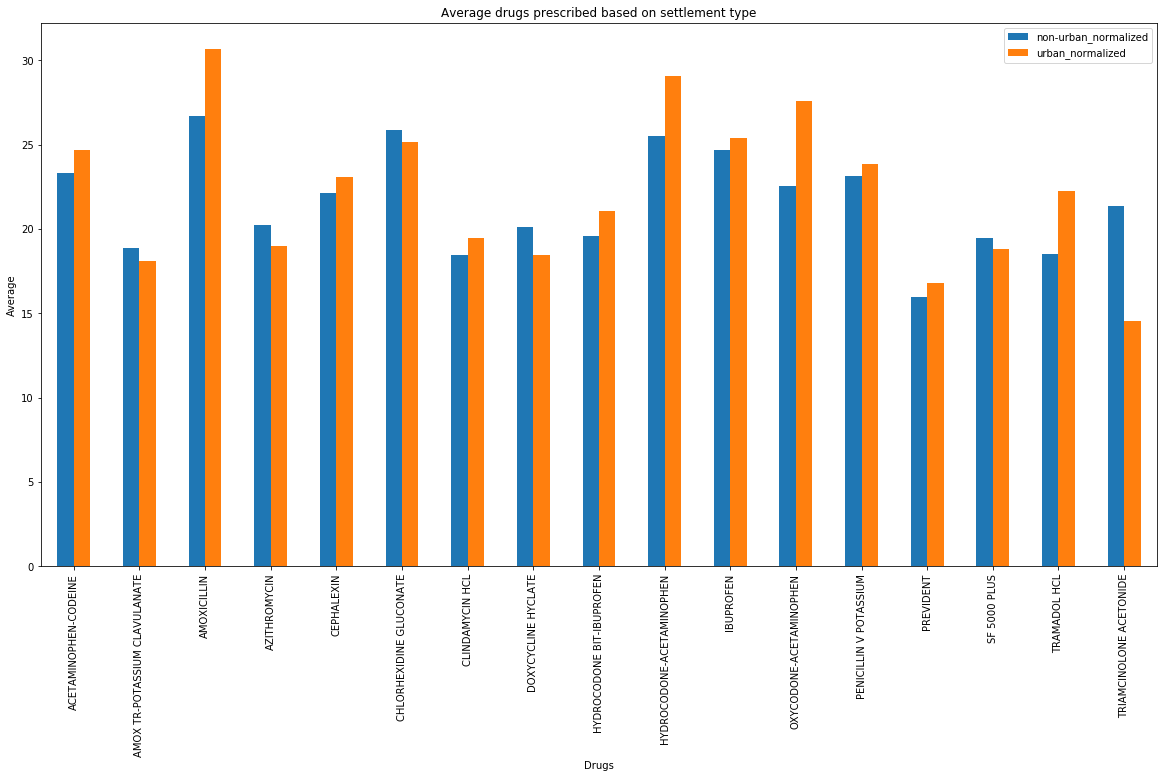

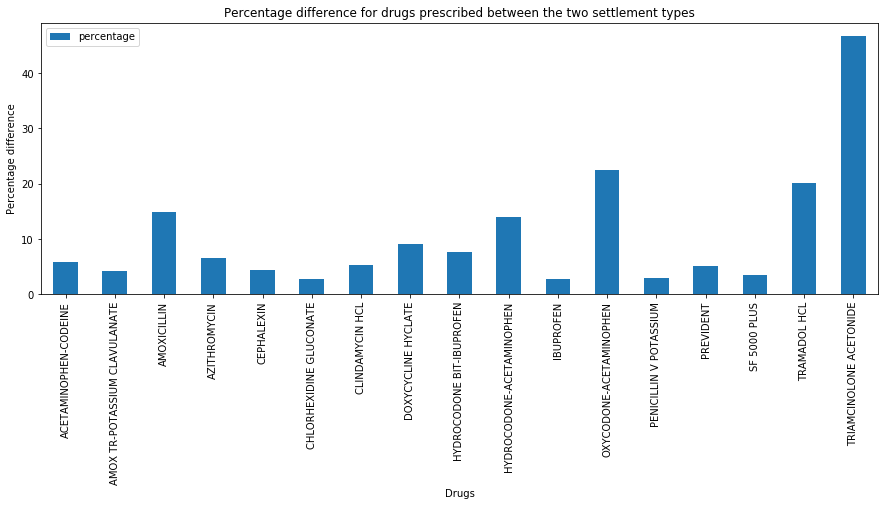

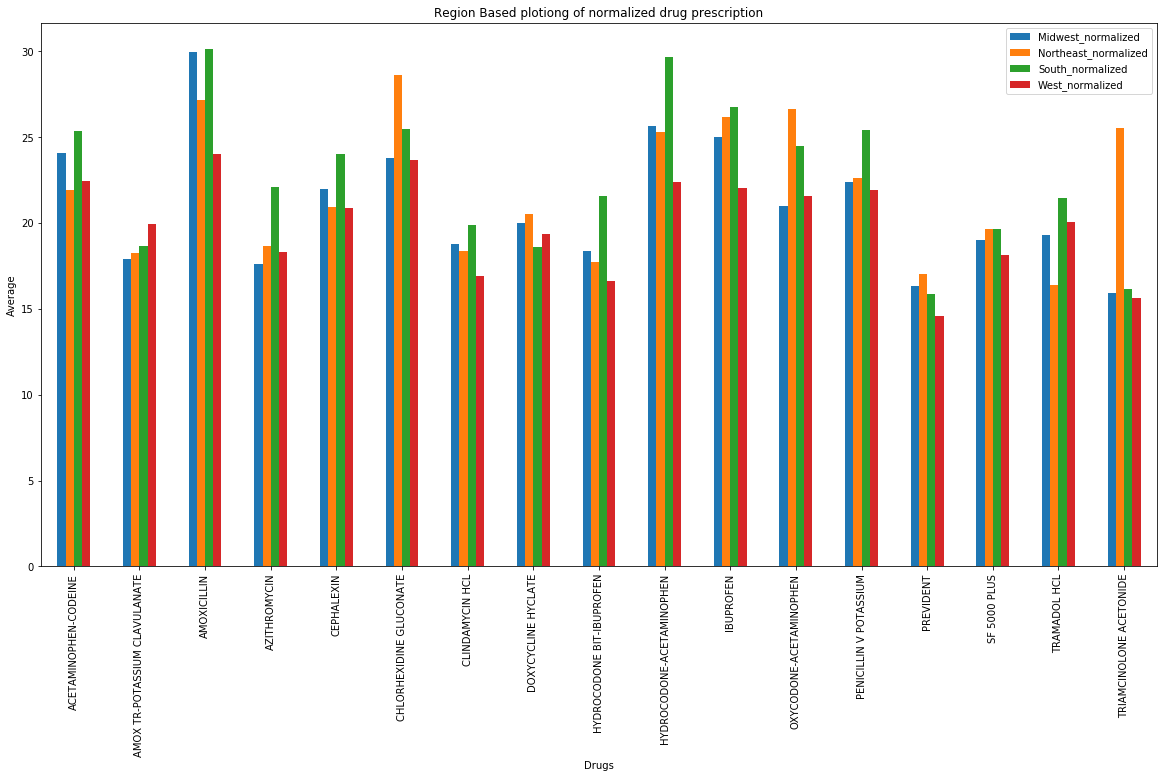

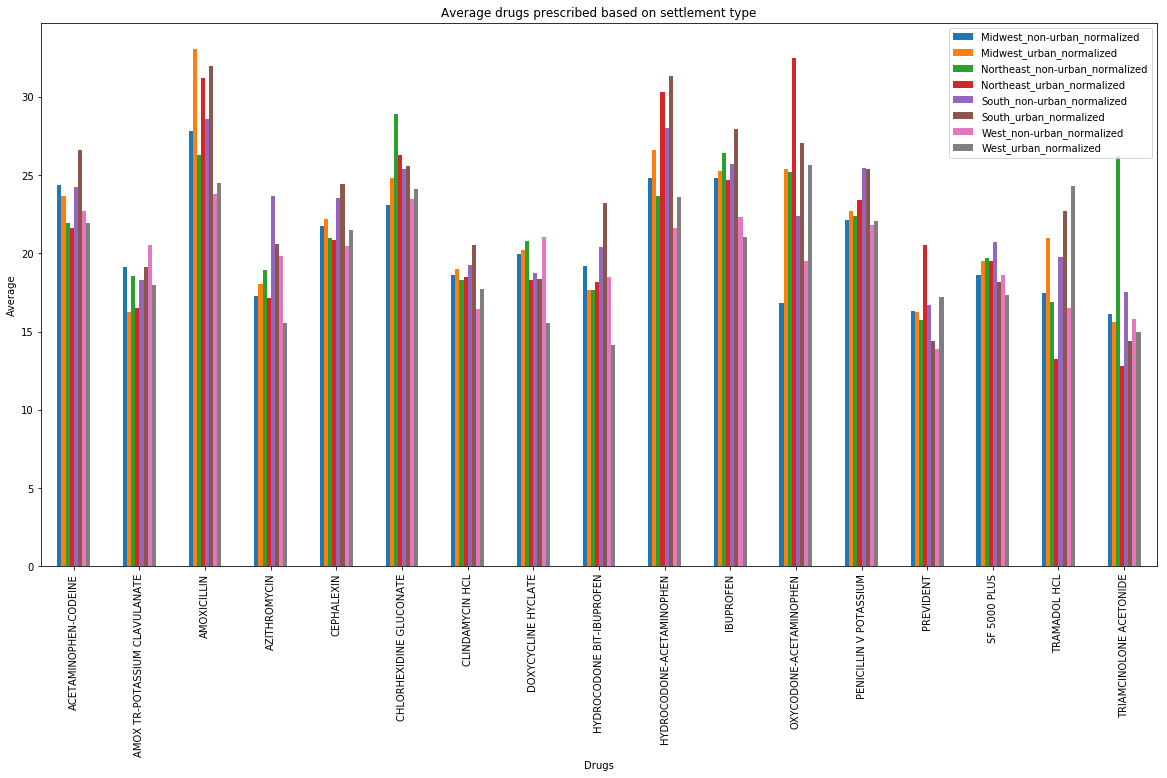

In [41]:
plotDistributions('General Practice')

for any drug ideally it is expected that irrespective of the settlement type of the doctor the drug will be perscribed in equal measures. But In the above graph we can creally see that some of the drugs are clearly preferred in a settlement compared to other.

In [42]:
#reducing lots of labels with only little info loss.

tempList = []
df_df_specialty_countlessthan400 = df_specialty_count.query('counts < 400')
for i in df_df_specialty_countlessthan400['specialty']:
    indices = dataframe_main.loc[dataframe_main['specialty'] == i].index.tolist()
    tempList.append(indices)  

#collect all the indices for these specialties to remove from the df_dataframe_main

indicesToDrop = [item for sublist in tempList for item in sublist]
dataframe_main.drop(dataframe_main.index[indicesToDrop], inplace=True)
dataframe_main.dropna(axis=1,how='all', inplace=True)
dataframe_main.shape

(227275, 2373)

In [43]:
#dataframe_main.head(2)

In [44]:
dataframe_main.drop(['npi', 'brand_name_rx_count', 'gender', 'generic_rx_count', 'region', 'settlement_type', 'years_practicing'], axis=1,inplace=True)

In [45]:
dataframe_main.columns.values[-10:]

array([u'ZYFLO CR', u'ZYLET', u'ZYLOPRIM', u'ZYMAXID', u'ZYPREXA',
       u'ZYPREXA RELPREVV', u'ZYPREXA ZYDIS', u'ZYTIGA', u'ZYVOX',
       u'specialty'], dtype=object)

In [46]:
label = dataframe_main.pop('specialty')
#dataframe_main.columns.values[-3:]

In [48]:
dataframe_main.fillna(value=0, inplace=True)

In [49]:
df_temp = dataframe_main.head(5)
df_temp

,1ST TIER UNIFINE PENTIPS,ABACAVIR,ABELCET,ABILIFY,ABILIFY DISCMELT,ABILIFY MAINTENA,ABRAXANE,ABSTRAL,ACAMPROSATE CALCIUM,ACANYA,...,ZYFLO,ZYFLO CR,ZYLET,ZYLOPRIM,ZYMAXID,ZYPREXA,ZYPREXA RELPREVV,ZYPREXA ZYDIS,ZYTIGA,ZYVOX
0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf =TfidfTransformer(norm=u'l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
data =tfidf.fit_transform(dataframe_main.values)

In [58]:
dataframe_main.head(2)

,1ST TIER UNIFINE PENTIPS,ABACAVIR,ABELCET,ABILIFY,ABILIFY DISCMELT,ABILIFY MAINTENA,ABRAXANE,ABSTRAL,ACAMPROSATE CALCIUM,ACANYA,...,ZYFLO,ZYFLO CR,ZYLET,ZYLOPRIM,ZYMAXID,ZYPREXA,ZYPREXA RELPREVV,ZYPREXA ZYDIS,ZYTIGA,ZYVOX
0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
type (dataframe_main.values)

numpy.ndarray

In [65]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
# load data

In [66]:
#label_encoded_y = LabelEncoder().fit_transform(y)
le = LabelEncoder()
#z1 = y.get_values()
#le.fit(label)
#le.classes_
y = le.fit_transform(label)


array([29, 17, 17, ..., 41, 13, 17])

In [70]:
from sklearn.decomposition import NMF
model = NMF(n_components=500, init='random', random_state=0, verbose=1)
boost_input = model.fit_transform(data, y=y)

violation: 1.0
violation: 0.359054704134
violation: 0.166067056479
violation: 0.0949916166454
violation: 0.0601409259246
violation: 0.0411330363525
violation: 0.0306422838575
violation: 0.0247059802003
violation: 0.0207229839544
violation: 0.0173086752693
violation: 0.013291366085
violation: 0.0106120438193
violation: 0.00991637009168
violation: 0.00974941650403
violation: 0.00891943682194
violation: 0.00815836600502
violation: 0.00777192078313
violation: 0.00751813096096
violation: 0.00735940999038
violation: 0.00730773930683
violation: 0.00684516436684
violation: 0.00593533808184
violation: 0.00544890111525
violation: 0.00529839522856
violation: 0.00499212368544
violation: 0.00466031776648
violation: 0.00443740524256
violation: 0.00419160192543
violation: 0.00390268825284
violation: 0.00365054479487
violation: 0.00347154513429
violation: 0.00328112760027
violation: 0.00307235970652
violation: 0.00287245038647
violation: 0.00269550103791
violation: 0.00257189881251
violation: 0.002470

In [ ]:
#new_data = model.transform(data)

In [76]:
type(data)

scipy.sparse.csr.csr_matrix

In [80]:
boost_input.shape

(227275, 500)

In [83]:
dir(boost_input)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_wrap__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__delslice__',
 '__div__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getslice__',
 '__gt__',
 '__hash__',
 '__hex__',
 '__iadd__',
 '__iand__',
 '__idiv__',
 '__ifloordiv__',
 '__ilshift__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__oct__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__rdivmod__',


In [ ]:
#le.inverse_transform(z)

In [84]:
X_train,X_test,y_train,y_test = train_test_split(boost_input,y,test_size=0.2, random_state=42)

In [85]:
y_train.shape

(181820,)

In [86]:
X_train.shape

(181820, 500)

In [ ]:
model = XGBClassifier(silent=False,seed=42)
#colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
#param_grid = dict(colsample_bylevel=colsample_bylevel)
param_grid = {
                'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]                
              }
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)


In [ ]:
# scoring="neg_log_loss", 
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)

In [ ]:
grid_result = grid_search.fit(X_train, y_train)

In [ ]:
# Get the estimator
print grid_result.best_estimator_

In [ ]:
model = grid_result.best_estimator_

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred.shape

In [ ]:
y_test.shape

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

In [ ]:
# XGBoost on Otto dataset, tune colsample_bylevel


#data = read_csv('train.csv')
#dataset = data.values

# split data into X and y
#X = dataset[:,0:94]
#y = dataset[:,94]
# encode string class values as integers
#label_encoded_y = LabelEncoder().fit_transform(y)
# grid search
#model = XGBClassifier()
#colsample_bylevel = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
#param_grid = dict(colsample_bylevel=colsample_bylevel)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
#grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
#grid_result = grid_search.fit(X, label_encoded_y)
## summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

    # plot

#pyplot.errorbar(colsample_bylevel, means, yerr=stds)
#pyplot.title("XGBoost colsample_bylevel vs Log Loss")
#pyplot.xlabel('colsample_bylevel')
#pyplot.ylabel('Log Loss')
#pyplot.savefig('colsample_bylevel.png')